# Tensorflow

Homework 3

In [1]:
import tensorflow as tf
import keras
from keras import layers, losses, optimizers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from keras.datasets import cifar10

Number of classes in CIFAR Train set: 10
CIFAR Train batch size: 64
Each image size: (32, 32, 3)
Sample labels from CIFAR Train set: [9, 5, 9, 3, 1]
Number of classes in CIFAR Test set: 10
CIFAR Test batch size: 64
Each image size: (32, 32, 3)
Sample labels from CIFAR Test set: [7, 0, 6, 9, 5]


2023-12-09 11:19:19.057749: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-09 11:19:19.095082: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-09 11:19:19.297342: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. I

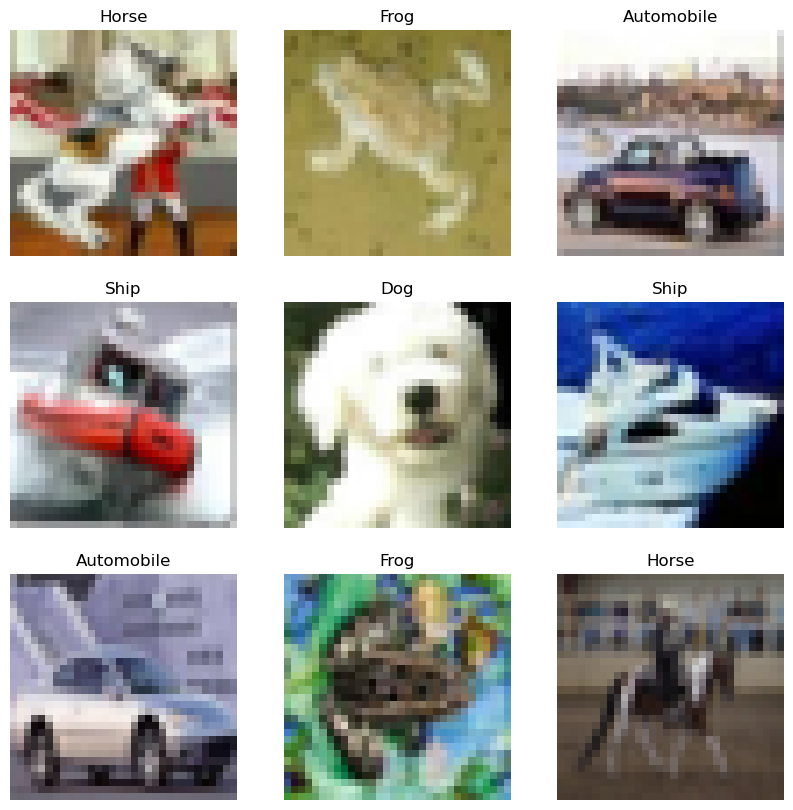

In [2]:
# 1.1 Prepare the Dataset

def prep_cifar(train_data, test_data, batch_size):
    # Function for preprocessing the images and labels
    def preprocessing_func(img, label):
        img = tf.cast(img, tf.float32)  # Cast image to float32
        img = (img / 128) - 1  # Normalize images to range [-1, 1]
        label = tf.one_hot(label, depth=10)  # One-hot encode the labels
        return img, label


    # Apply the preprocessing function to the training and test datasets
    train_data = train_data.map(preprocessing_func).shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_data = test_data.map(preprocessing_func).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return train_data, test_data


def get_familiar_with_data(dataset, name, num_classes):
    # Print basic information about the dataset
    print(f"Number of classes in {name} set: {num_classes}")

    # Display the first batch of images to get a sense of the data
    for images, labels in dataset.take(1):
        print(f"{name} batch size:", images.shape[0])
        print("Each image size:", images.shape[1:])
        sample_labels = [np.argmax(label) for label in labels.numpy()]
        print(f"Sample labels from {name} set:", sample_labels[:5]) # Just 5 images



def visualize_data(dataset, num_images=9):
    # Names of classes in CIFAR-10
    class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                   'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

    # Visualize a batch of images
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            img = ((images[i].numpy() + 1) * 128).astype("uint8")  # Denormalize image
            plt.imshow(img)
            plt.title(class_names[np.argmax(labels[i])])  # Display image title as class name
            plt.axis("off")

    plt.show()


# Load CIFAR10 dataset and split it into training and test sets
(train_data, test_data), dataset_info = tfds.load('cifar10', split=['train', 'test'], as_supervised=True, with_info=True)

# Preprocess the data using the prep_cifar function
batch_size = 64
train_data, test_data = prep_cifar(train_data, test_data, batch_size)

# Get the number of classes in the dataset
num_classes = dataset_info.features['label'].num_classes

# Display basic information about the training and test datasets
get_familiar_with_data(train_data, 'CIFAR Train', num_classes)
get_familiar_with_data(test_data, 'CIFAR Test', num_classes)

# Visualize the training data
visualize_data(train_data)

In [3]:
#1.2 The CNN Model

class CNN():
    # Initialize the CNN model with various hyperparameters
    def __init__(self, input_size=(32, 32, 3), num_filters=[32, 64, 128], kernel_size=[(3,3), (3,3), (3,3)], strides=[(1,1), (1,1), (1,1)], conv_activation='relu', cnn_pool_type="max_pool",
                 padding="valid", use_bias=False, dense_activation='relu', dense_sizes=[256], num_classes=10, flatten_type="global_max", name="CNN_model"):

        self.input_size = input_size
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.conv_activation = conv_activation
        self.cnn_pool_type = cnn_pool_type
        self.padding = padding
        self.use_bias = use_bias
        self.dense_activation = dense_activation
        self.dense_sizes = dense_sizes
        self.num_classes = num_classes
        self.flatten_type = flatten_type
        self.name = name
        self.last_performance = {
            'train_loss_results': [],
            'train_accuracy_results': [],
            'test_loss_results': [],
            'test_accuracy_results': []
        }

        self.model = None
        self.create_cnn()



    # Method to construct the CNN architecture
    def create_cnn(self):
        inputs = layers.Input(shape=(self.input_size), dtype=tf.float32)
        x = inputs

        # Constructing the convolutional layers with specified filters, kernel sizes, and strides
        for i, num_filter in enumerate(self.num_filters):
            x = layers.Conv2D(num_filter, self.kernel_size[i], self.strides[i], self.padding, activation=self.conv_activation, use_bias=self.use_bias)(x)
            x = layers.BatchNormalization()(x)

            # Adding pooling layer based on the specified pool type
            if self.cnn_pool_type == "max_pool":
                 x = layers.MaxPool2D()(x)
            else:
                 x = layers.AveragePooling2D()(x)

         # Flatten the output for the dense (fully connected) layers
        if self.flatten_type == "global_max":
            x = layers.GlobalMaxPool2D()(x)
        else:
            x = layers.GlobalAveragePooling2D()(x)

        # Adding dense layers with specified sizes and activation function
        for dense_size in self.dense_sizes:
            x = layers.Dense(dense_size, activation=self.dense_activation)(x)

        # Output layer with softmax activation for classification
        y = layers.Dense(units=self.num_classes, activation='softmax')(x)

        # Compiling the model
        self.model = keras.Model(inputs=inputs, outputs=y, name=self.name)
        self.model.summary()


    # 1.3 Training the network
    # Training method for the CNN model
    def train(self, train_data, test_data, epochs=15, learning_rate=0.01, optimizer='adam'):

        # Setup the optimizer
        if optimizer == 'adam':
            optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
        else:
            optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=learning_rate)

        # Loss function for training
        loss_f = tf.keras.losses.CategoricalCrossentropy()

        # Training loop over epochs
        for epoch in range(epochs):
            epoch_loss_avg = tf.keras.metrics.Mean()
            epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

            # Training step for each batch
            for image, label in train_data:
                with tf.GradientTape() as tape:
                    pred = self.model(image)
                    loss = loss_f(label, pred)
                gradients = tape.gradient(loss, self.model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
                epoch_loss_avg.update_state(loss)
                epoch_accuracy.update_state(label, pred)

            # Logging training loss and accuracy
            self.last_performance['train_loss_results'].append(epoch_loss_avg.result())
            self.last_performance['train_accuracy_results'].append(epoch_accuracy.result())

            # Evaluating the model on test data
            test_loss, test_accuracy = self.evaluate(test_data)
            self.last_performance['test_loss_results'].append(test_loss)
            self.last_performance['test_accuracy_results'].append(test_accuracy)

            # Printing epoch results
            print(f"Epoch {epoch + 1}/{epochs}: "
                  f"Train Loss: {epoch_loss_avg.result():.4f}, Train Accuracy: {epoch_accuracy.result():.4%}, "
                  f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4%}")


    # Evaluation method for the CNN model
    def evaluate(self, test_data):
        loss_f = tf.keras.losses.CategoricalCrossentropy()
        loss_list = []
        correct_predictions = 0
        total_samples = 0

        # Iterating over each batch in test data
        for image, label in test_data:
            pred = self.model(image)
            loss = loss_f(label, pred)
            loss_list.append(loss)

            # Counting correct predictions
            correct_predictions += np.sum(np.argmax(label, axis=-1) == np.argmax(pred, axis=-1))
            total_samples += label.shape[0]

        # Calculating average loss and accuracy
        average_loss = np.mean(loss_list)
        accuracy = correct_predictions / total_samples
        return average_loss, accuracy


    # 1.4 Visualization
    # Method to visualize training and testing performance over epochs
    def visualize_performance(self):
        epochs = np.arange(1, len(self.last_performance['train_loss_results']) + 1)
        plt.figure(figsize=(12, 6))

        # Plotting training and testing losses
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.last_performance['train_loss_results'], label='Train Loss', marker='o')
        plt.plot(epochs, self.last_performance['test_loss_results'], label='Test Loss', marker='o')
        plt.title('Losses Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plotting training and testing accuracies
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.last_performance['train_accuracy_results'], label='Train Accuracy', marker='o')
        plt.plot(epochs, self.last_performance['test_accuracy_results'], label='Test Accuracy', marker='o')
        plt.title('Accuracies Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()



Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        864       
                                                                 
 batch_normalization (Batch  (None, 30, 30, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18432     
                                                                 
 batch_normalization_1 (Bat  (None, 13, 13, 64)        25

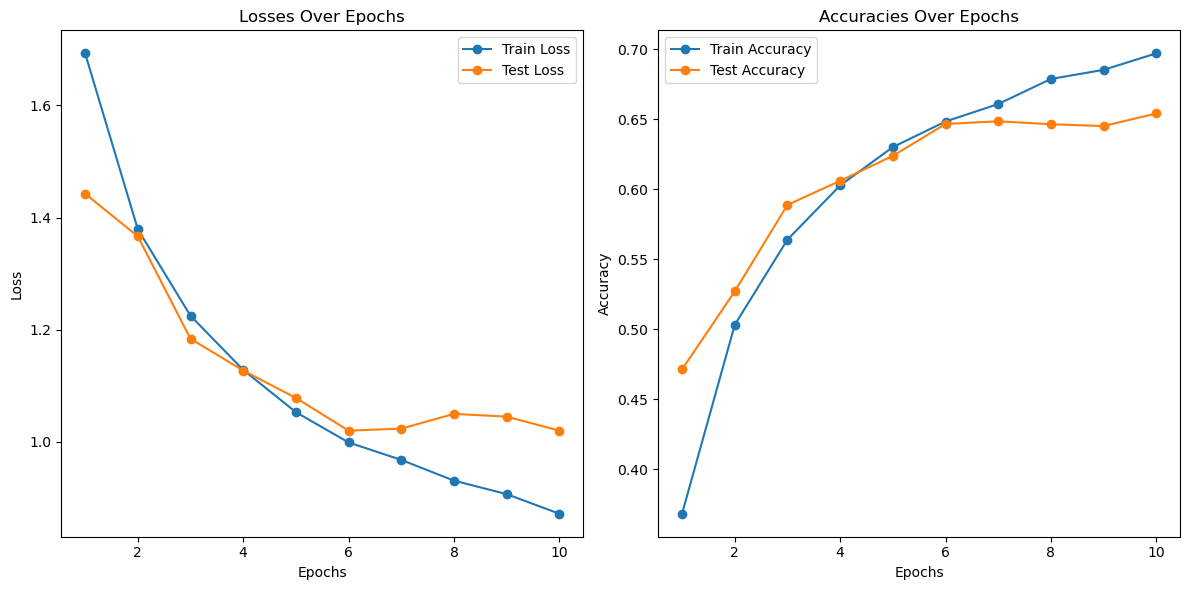

In [4]:
# Default Set of Hyperparameters for Testing Purposes
cnn_model = CNN()
cnn_model.train(train_data, test_data, epochs=10, learning_rate=0.01, optimizer='adam')
cnn_model.visualize_performance()


Model: "Set_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        864       
                                                                 
 batch_normalization_3 (Bat  (None, 30, 30, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18432     
                                                                 
 batch_normalization_4 (Bat  (None, 13, 13, 64)        256   

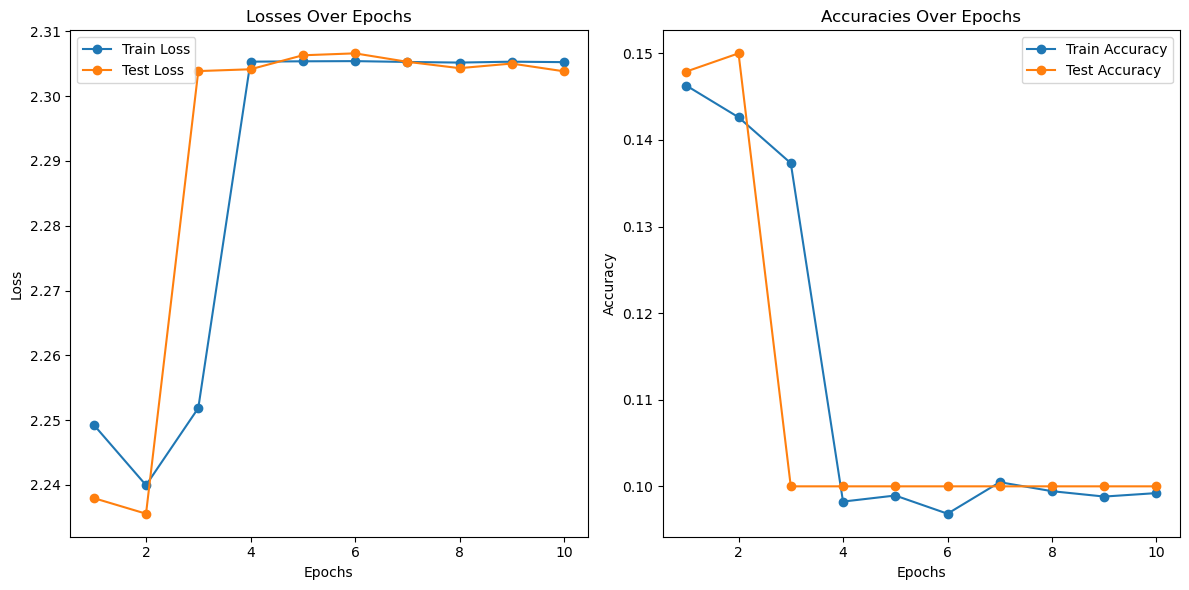

In [5]:
# 2 Adjust hyperparameters and architecture

# Set 1 Configuration:
# Initialize a CNN model with a specific configuration

set1_model = CNN(
    num_filters=[32, 64, 128],   # Number of filters for each convolutional layer
    kernel_size=[(3,3), (3,3), (3,3)],   # Kernel size for each convolutional layer
    strides=[(1,1), (1,1), (1,1)],   # Strides for each convolutional layer
    conv_activation='elu',    # Activation function for the convolutional layers
    cnn_pool_type='max_pool',   # Pooling type (MaxPooling)
    padding='valid',   # Padding type for convolutional layers
    use_bias=False,   # Whether to use a bias vector in the convolutional layers
    dense_activation='softmax',   # Activation function for the dense layer
    dense_sizes=[128],   # Number of neurons in the dense layer
    flatten_type='global_max',   # Type of flattening (GlobalMaxPooling)
    name="Set_1",   # Name of the model
)

# Load CIFAR-10 dataset, split into training and test data
train_data1, test_data1 = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)

# Preprocess the data for set 1 with specific batch size
# The preprocessing includes normalization and one-hot encoding
batch_size_set1 = 32   # Batch size for training and testing
train_data_set1, test_data_set1 = prep_cifar(train_data1, test_data1, batch_size_set1)

# Train the Set 1 model using the training data
# Training for 3 epochs with the specified batch size
set1_model.train(train_data_set1, test_data_set1, epochs=10)


# Visualize the training performance of Set 1 model
# This includes plotting the training and testing loss and accuracy for each epoch
set1_model.visualize_performance()


Model: "Set_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 32)        384       
                                                                 
 batch_normalization_6 (Bat  (None, 16, 16, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 6, 6, 64)          18432     
                                                                 
 batch_normalization_7 (Bat  (None, 6, 6, 64)          256   

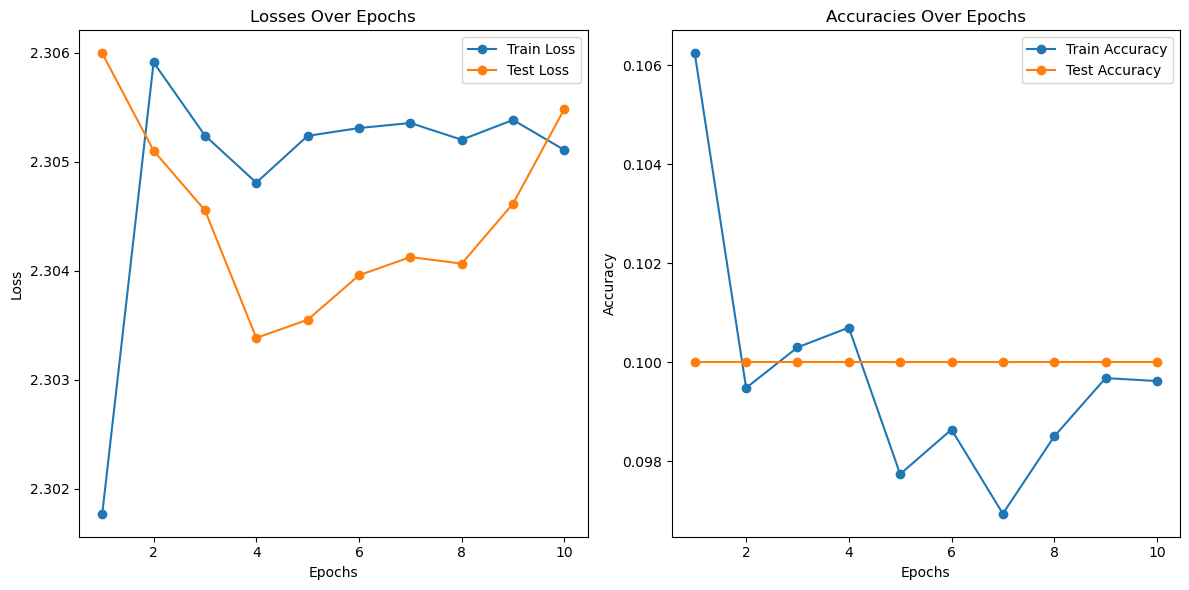

In [6]:
# Set 2 Configuration:
# Initialize a CNN model with a specific configuration

set2_model = CNN(
    num_filters=[32, 64, 128],
    kernel_size=[(2,2), (3,3), (2,2)],
    strides=[(2,2), (1,1), (1,1)],
    conv_activation='elu',
    cnn_pool_type='max_pool',
    padding='valid',
    use_bias=False,
    dense_activation='softmax',
    dense_sizes=[128],
    flatten_type='global_max',
    name="Set_2",
)
# Load CIFAR-10 dataset, split into training and test data
train_data2, test_data2 = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)

# Preprocess the data for set 2 with specific batch size
# The preprocessing includes normalization and one-hot encoding
batch_size_set2 = 32   # Batch size for training and testing
train_data_set2, test_data_set2 = prep_cifar(train_data2, test_data2, batch_size_set2)

# Train the Set 2 model using the training data
# Training for 3 epochs with the specified batch size
set2_model.train(train_data_set2, test_data_set2, epochs=10)


# Visualize the training performance of Set 2 model
# This includes plotting the training and testing loss and accuracy for each epoch
set2_model.visualize_performance()


Model: "Set_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        832       
                                                                 
 batch_normalization_9 (Bat  (None, 16, 16, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 6, 6, 128)         73856     
                                                                 
 batch_normalization_10 (Ba  (None, 6, 6, 128)         512   

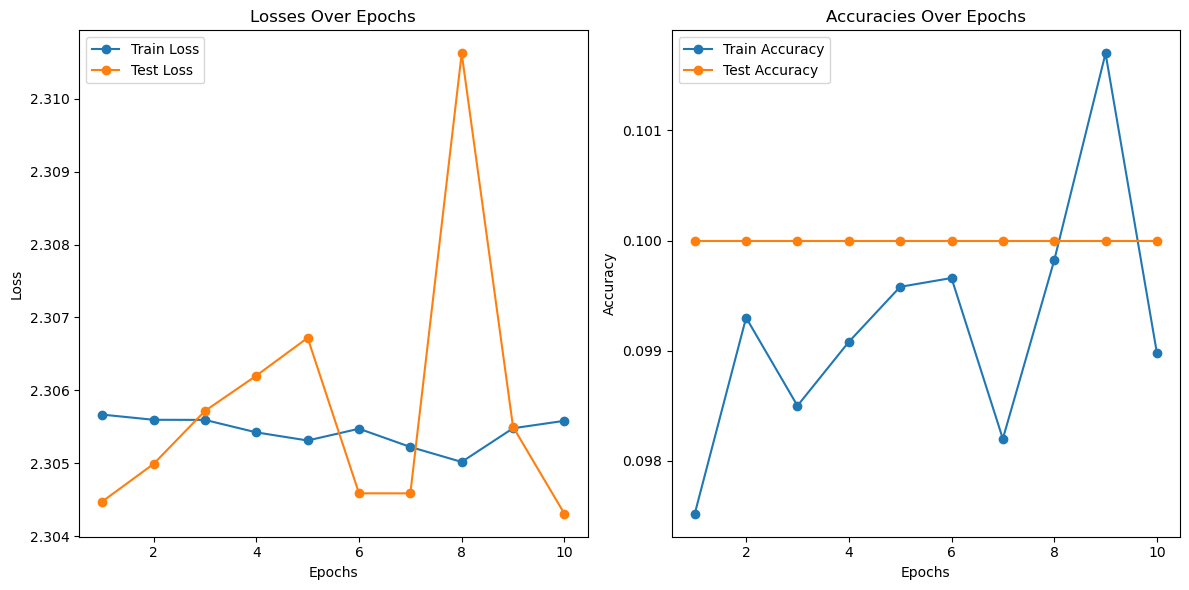

In [7]:
# Set 3:
set3_model = CNN(
    num_filters=[64, 128, 128],
    kernel_size=[(2,2), (3,3), (2,2)],
    strides=[(2,2), (1,1), (1,1)],
    conv_activation='relu',
    cnn_pool_type='max_pool',
    padding='valid',
    use_bias=True,
    dense_activation='softmax',
    dense_sizes=[128],
    flatten_type='global_max',
    name="Set_3",
)

# Load CIFAR-10 dataset, split into training and test data
train_data3, test_data3 = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)

# Preprocess the data for set 3 with specific batch size
# The preprocessing includes normalization and one-hot encoding
batch_size_set3 = 32   # Batch size for training and testing
train_data_set3, test_data_set3 = prep_cifar(train_data3, test_data3, batch_size_set3)

# Train the Set 3 model using the training data
# Training for 3 epochs with the specified batch size
set3_model.train(train_data_set3, test_data_set3, epochs=10)


# Visualize the training performance of Set 3 model
# This includes plotting the training and testing loss and accuracy for each epoch
set3_model.visualize_performance()

Model: "Set_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 64)        832       
                                                                 
 batch_normalization_12 (Ba  (None, 16, 16, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 8, 8, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 6, 6, 128)         73856     
                                                                 
 batch_normalization_13 (Ba  (None, 6, 6, 128)         512   

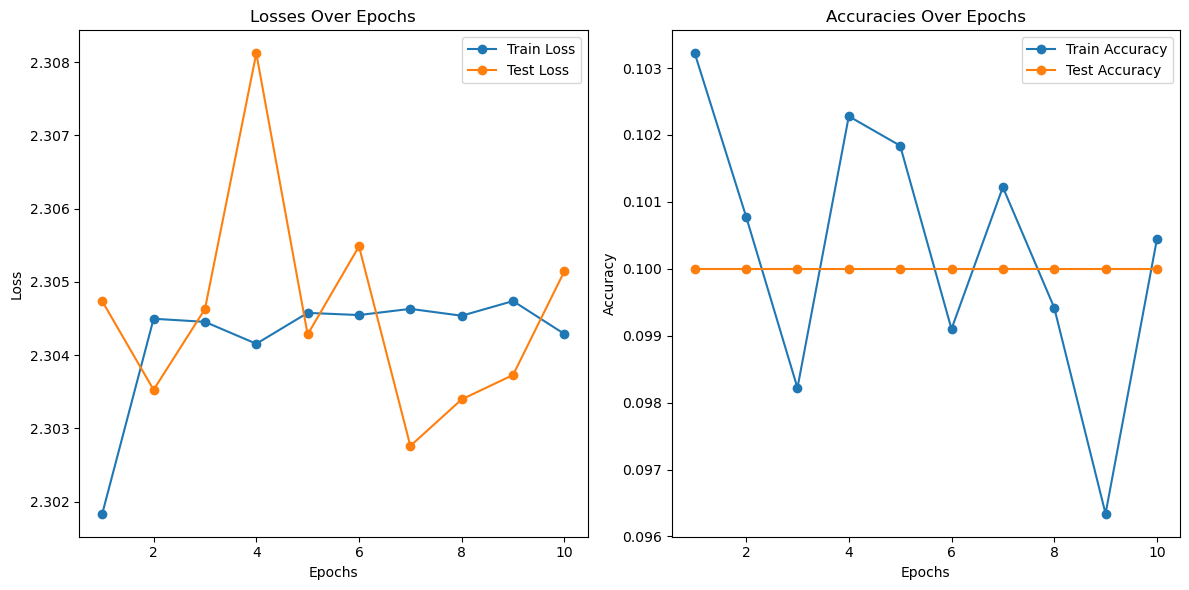

In [8]:
# Set 4:
set4_model = CNN(
    num_filters=[64, 128, 128],
    kernel_size=[(2,2), (3,3), (2,2)],
    strides=[(2,2), (1,1), (1,1)],
    conv_activation='relu',
    cnn_pool_type='max_pool',
    padding='valid',
    use_bias=True,
    dense_activation='softmax',
    dense_sizes=[128],
    flatten_type='global_max',
    name="Set_4",
)

# Load CIFAR-10 dataset, split into training and test data
train_data4, test_data4 = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)

# Preprocess the data for set 4 with specific batch size
# The preprocessing includes normalization and one-hot encoding
batch_size_set4 = 64   # Batch size for training and testing
train_data_set4, test_data_set4 = prep_cifar(train_data4, test_data4, batch_size_set4)

# Train the Set 4 model using the training data
# Training for 3 epochs with the specified batch size
set4_model.train(train_data_set4, test_data_set4, epochs=10)


# Visualize the training performance of Set 4 model
# This includes plotting the training and testing loss and accuracy for each epoch
set4_model.visualize_performance()

Model: "Set_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 15, 15, 64)        1792      
                                                                 
 batch_normalization_15 (Ba  (None, 15, 15, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 3, 3, 64)          36928     
                                                                 
 batch_normalization_16 (Ba  (None, 3, 3, 64)          256   

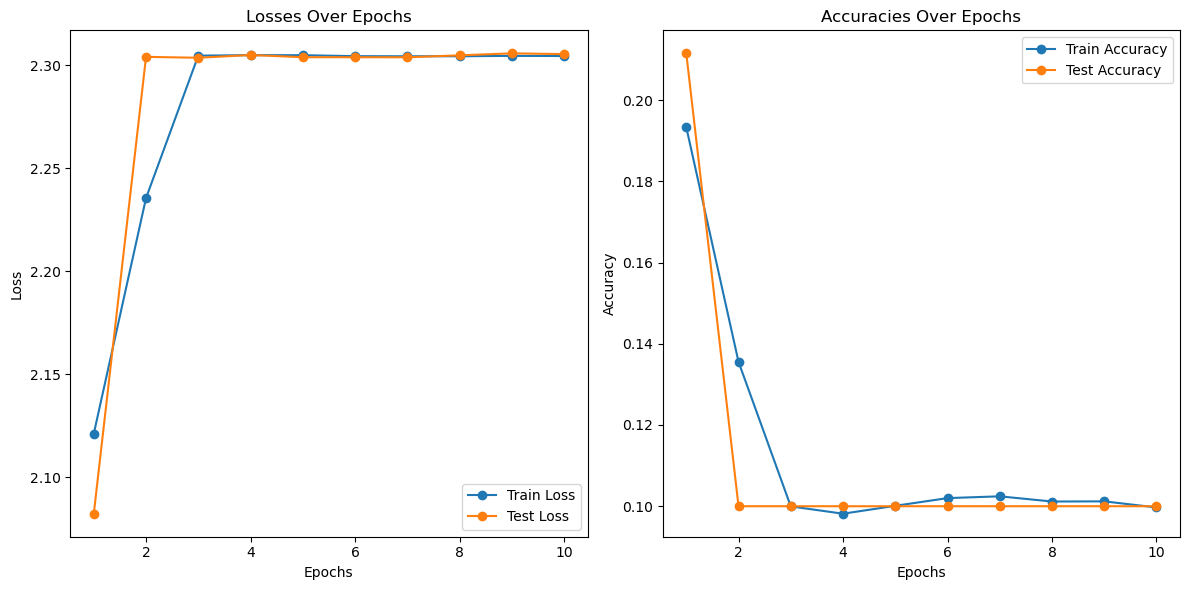

In [9]:
# Set 5:
set5_model = CNN(
    num_filters=[64, 64],
    kernel_size=[(3,3), (3,3)],
    strides=[(2,2), (2,2)],
    conv_activation='relu',
    cnn_pool_type='max_pool',
    padding='valid',
    use_bias=True,
    dense_activation='softmax',
    dense_sizes=[128],
    flatten_type='global_max',
    name="Set_5",
)
# Load CIFAR-10 dataset, split into training and test data
train_data5, test_data5 = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)

# Preprocess the data for set 5 with specific batch size
# The preprocessing includes normalization and one-hot encoding
batch_size_set5 = 64   # Batch size for training and testing
train_data_set5, test_data_set5 = prep_cifar(train_data5, test_data5, batch_size_set5)

# Train the Set 5 model using the training data
# Training for 3 epochs with the specified batch size
set5_model.train(train_data_set5, test_data_set5, epochs=10)


# Visualize the training performance of Set 5 model
# This includes plotting the training and testing loss and accuracy for each epoch
set5_model.visualize_performance()

Model: "Set_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 15, 15, 64)        1792      
                                                                 
 batch_normalization_17 (Ba  (None, 15, 15, 64)        256       
 tchNormalization)                                               
                                                                 
 average_pooling2d (Average  (None, 7, 7, 64)          0         
 Pooling2D)                                                      
                                                                 
 conv2d_18 (Conv2D)          (None, 3, 3, 128)         73856     
                                                                 
 batch_normalization_18 (Ba  (None, 3, 3, 128)         512   

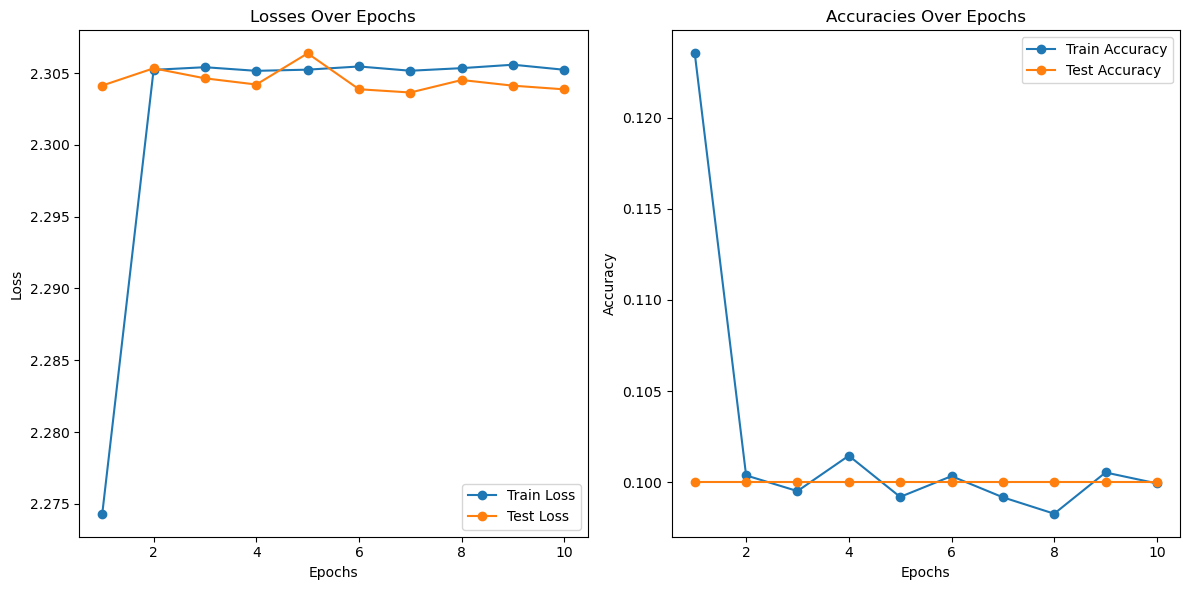

In [10]:
# Set 6:
set6_model = CNN(
    num_filters=[64, 128],
    kernel_size=[(3,3), (3,3)],
    strides=[(2,2), (2,2)],
    conv_activation='relu',
    cnn_pool_type='av_pool',
    padding='valid',
    use_bias=True,
    dense_activation='softmax',
    dense_sizes=[128],
    flatten_type='av_max',
    name="Set_6",
)
# Load CIFAR-10 dataset, split into training and test data
train_data6, test_data6 = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)

# Preprocess the data for set 6 with specific batch size
# The preprocessing includes normalization and one-hot encoding
batch_size_set6 = 32   # Batch size for training and testing
train_data_set6, test_data_set6 = prep_cifar(train_data6, test_data6, batch_size_set6)

# Train the Set 6 model using the training data
# Training for 3 epochs with the specified batch size
set6_model.train(train_data_set6, test_data_set6, epochs=10)


# Visualize the training performance of Set 6 model
# This includes plotting the training and testing loss and accuracy for each epoch
set6_model.visualize_performance()

Model: "Set_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 30, 30, 64)        1728      
                                                                 
 batch_normalization_19 (Ba  (None, 30, 30, 64)        256       
 tchNormalization)                                               
                                                                 
 average_pooling2d_2 (Avera  (None, 15, 15, 64)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_20 (Conv2D)          (None, 13, 13, 128)       73728     
                                                                 
 batch_normalization_20 (Ba  (None, 13, 13, 128)       512   

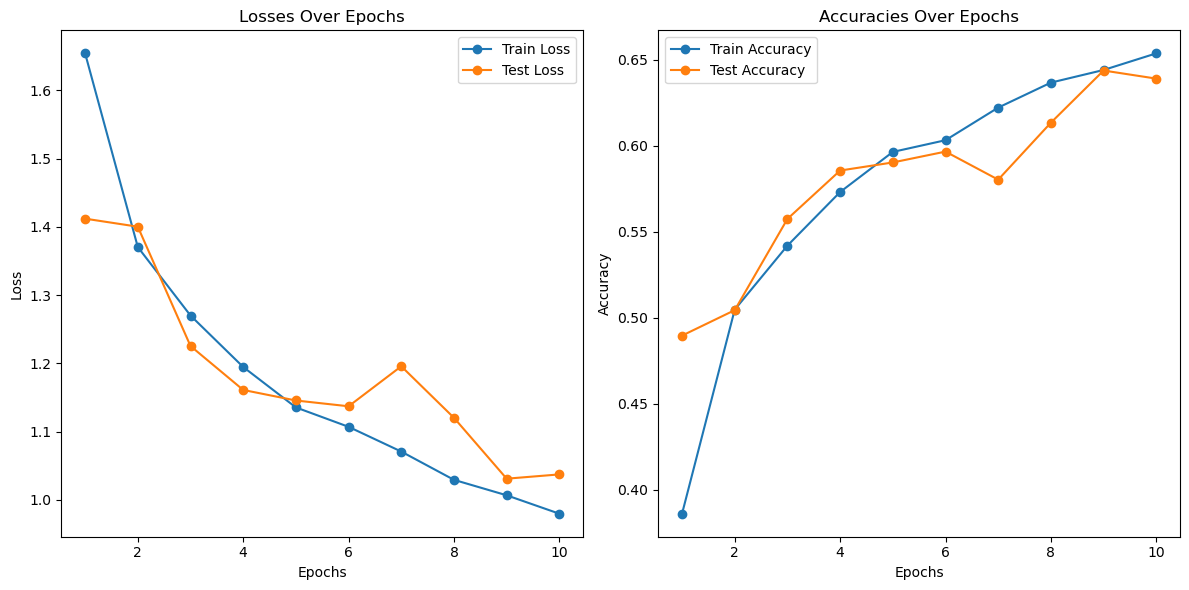

In [11]:
# Set 7:
set7_model = CNN(
    num_filters=[64, 128],
    kernel_size=[(3,3), (3,3)],
    strides=[(1,1), (1,1)],
    conv_activation='relu',
    cnn_pool_type='av_pool',
    padding='valid',
    use_bias=False,
    dense_activation='tanh',
    dense_sizes=[128],
    flatten_type='av_max',
    name="Set_7",
)

# Load CIFAR-10 dataset, split into training and test data
train_data7, test_data7 = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)

# Preprocess the data for set 7 with specific batch size
# The preprocessing includes normalization and one-hot encoding
batch_size_set7 = 64   # Batch size for training and testing
train_data_set7, test_data_set7 = prep_cifar(train_data7, test_data7, batch_size_set7)

# Train the Set 7 model using the training data
# Training for 3 epochs with the specified batch size
set7_model.train(train_data_set7, test_data_set7, epochs=10)


# Visualize the training performance of Set 7 model
# This includes plotting the training and testing loss and accuracy for each epoch
set7_model.visualize_performance()

Model: "Set_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 31, 31, 32)        384       
                                                                 
 batch_normalization_21 (Ba  (None, 31, 31, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 14, 14, 64)        8192      
                                                                 
 batch_normalization_22 (Ba  (None, 14, 14, 64)        256   

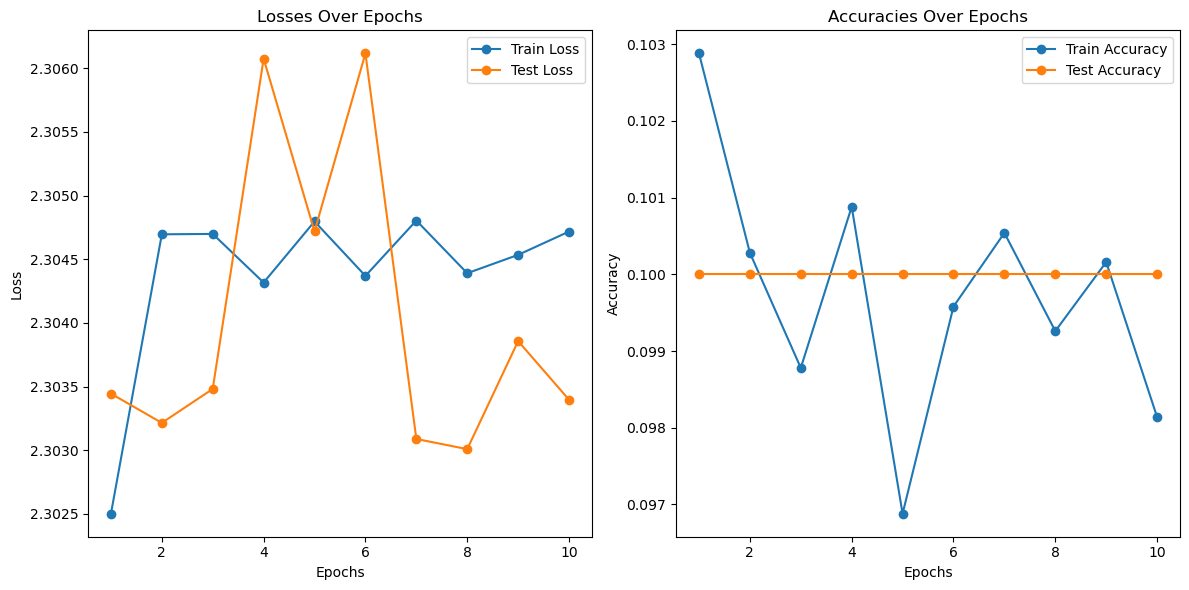

In [12]:
# Set 8:
set8_model = CNN(
    num_filters=[32, 64, 128, 128],
    kernel_size=[(2,2), (2,2), (2,2), (2,2)],
    strides=[(1,1), (1,1), (1,1), (1,1)],
    conv_activation='elu',
    cnn_pool_type= 'max_pool',
    padding='valid',
    use_bias=False,
    dense_activation='softmax',
    dense_sizes=[128],
    flatten_type='global_max',
    name="Set_8",
)
# Load CIFAR-10 dataset, split into training and test data
train_data8, test_data8 = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)

# Preprocess the data for set 8 with specific batch size
# The preprocessing includes normalization and one-hot encoding
batch_size_set8 = 64   # Batch size for training and testing
train_data_set8, test_data_set8 = prep_cifar(train_data8, test_data8, batch_size_set8)

# Train the Set 8 model using the training data
# Training for 3 epochs with the specified batch size
set8_model.train(train_data_set8, test_data_set8, epochs=10)


# Visualize the training performance of Set 8 model
# This includes plotting the training and testing loss and accuracy for each epoch
set8_model.visualize_performance()